# Compare JRA55 versus ERA forcing

NEMO uses pre-calculated weights files to go from JRA55 files read in to the atmospheric forcing. The weights files are called "w_bicubic.nc" and "w_bilin.nc". The frequency of the variables is 3 hours, separated into yearly files. 

Variables read in by NEMO: sn_wndi (uas), sn_wndj (vas), sn_qsr (rsds), sn_qlw (rlds), sn_tair (tas), sn_humi (huss), sn_prec (tprecip), sn_snow (prsn), sn_slp (psl).

Not used by NEMO: sn_uoatm, sn_voatm, sn_cc, sn_hpgi, sn_hpgj

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cmocean
import pickle

### Literature evaluation

Variables
- Precipitation: https://doi.org/10.1175/JCLI-D-20-0044.1 (don't decide on one that fits best)
    - Similar spatial patterns over Southern Ocean among reanalyses between 2000-2010
    - Different annual means and interannual patterns
    - ERA-interim produces the smallest ppt (less snowfall than others), JRA-55 produces more rain than others. ERA5 similar to JRA-55, but ERA5 produces snowfall at lower latitudes.
    - Eastern Antarctic ppt > western
    - ERA5 most spurious ppt in Ross Sea region
- Air temperature: https://doi.org/10.1016/j.atmosres.2019.04.029 --- assessed based on weather stations
    - In general, mean absolute error is higher in winter than in summer
    - ERA-interim best represents interannual variability in monthly Tair 1979-2010 (1979 onwards b/c of satellite data), JRA-55 pretty close too
    - All reanalyses overestimate trend in air temperature for AIS.
- Wind patterns
- Radiation budget
- Sea level pressure
- Humidity

1992-1996 observational dataset: https://doi.org/10.1029/2019JD030897 (mostly Weddell Sea)
- Humidity, wind speeds, cloud cover, radiation
- ERA-interim most reliable, JRA least favorable

But, JRA55 covers from 1958 to 2020, whereas ERA-interim only covers from 1979 onwards. Actually ERA-5 covers from 1950 onwards.

#### Functions

In [2]:
def prepare_plot(figsize=(15, 15), dpi=300):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    # ax.coastlines(); 
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

#### Load datasets

In [3]:
year        = 1979
folder_JRA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/JRA55-forcing/'
folder_ERA  = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/ERA5-forcing/'
ERA_dataset = xr.open_dataset(f'{folder_ERA}ERA5-1979-1981-3h.nc')
ERA_1979    = ERA_dataset.sel(time=slice(ERA_dataset.time[0], ERA_dataset.time[2919]), 
                              latitude=slice(-50,-90,2), longitude=slice(-180, 180, 2)) # subsample to reduce size
# ERA_qsr    = ???
# ERA_qlw    = ???
# ERA_humid  = ???

In [4]:
# Load polygon from disc
with open('/home/users/birgal/data/IBCSO_isobath_1000m_polygon', "rb") as poly_file:
    isobath_1000m_polygon = pickle.load(poly_file)

### Visual comparison

In [5]:
# Definitions used for plotting

# To make circular maps:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

# Isobath 2000 m polygon
x_iso, y_iso = isobath_1000m_polygon.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso)) # need to separate longitudes because otherwise matplotlib plotting artifact
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

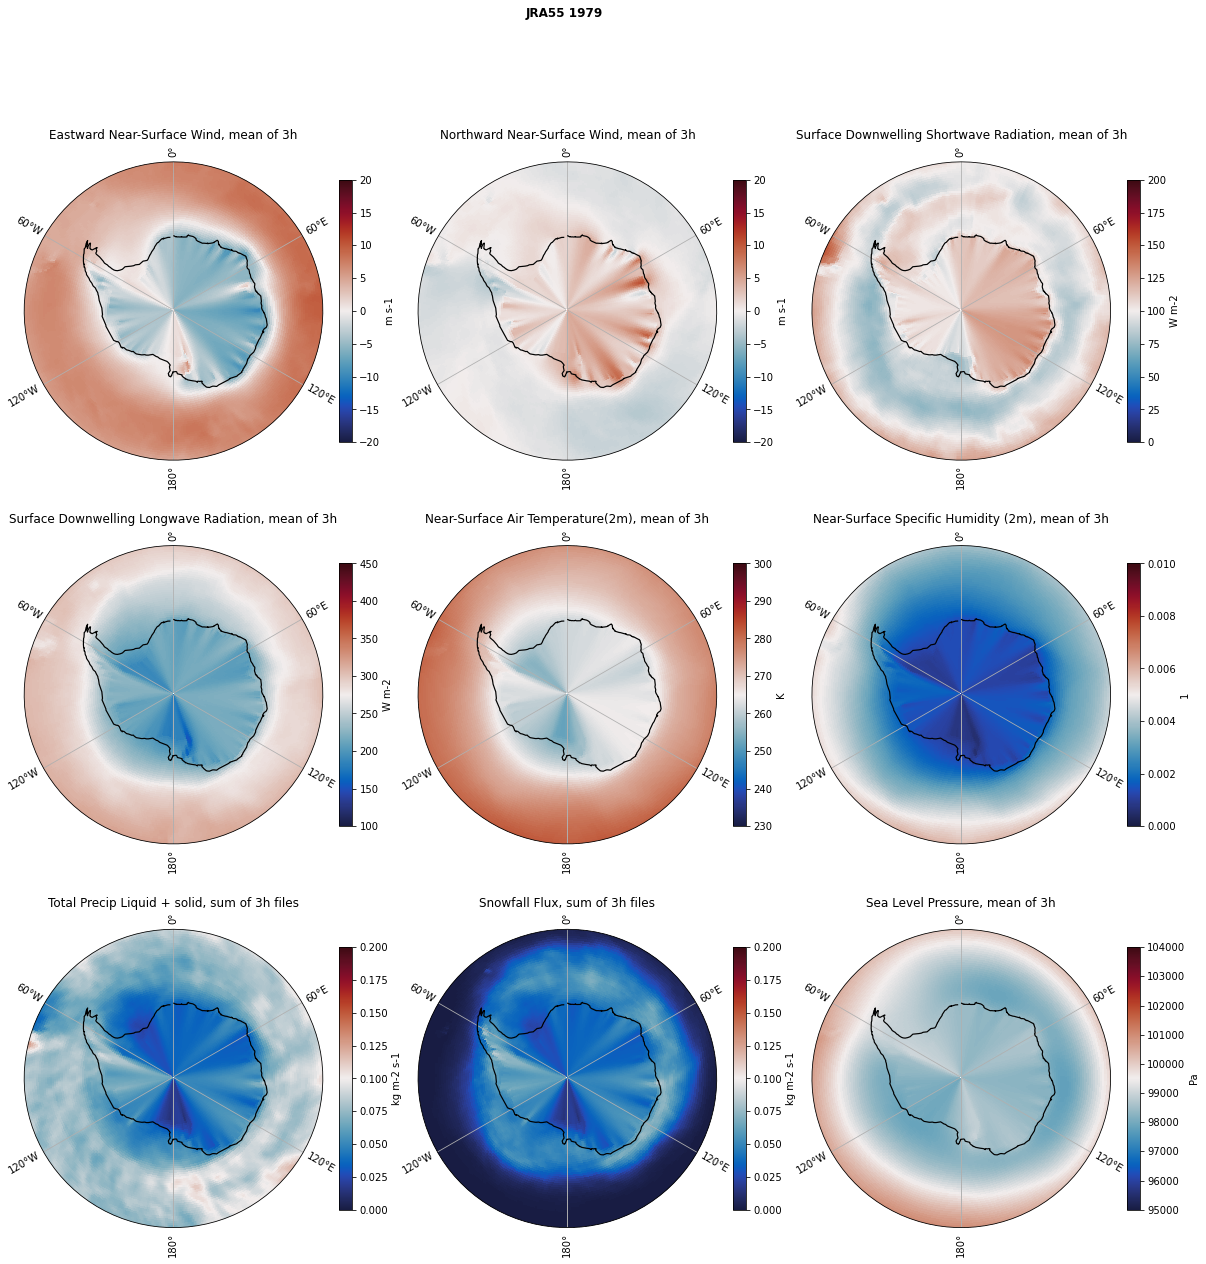

In [6]:
fig, ax = plt.subplots(3,3, figsize=(20,20), subplot_kw={'projection': ccrs.SouthPolarStereo()})

fig.suptitle('JRA55 1979', fontweight='bold')

JRA_vars = ['uas', 'vas', 'rsds', 'rlds', 'tas', 'huss', 'tprecip', 'prsn', 'psl']
vmins    = [-20, -20, 0, 100, 230, 0, 0, 0, 95000]
vmaxs    = [20, 20, 200, 450, 300, 0.01, 0.2, 0.2, 104000]
kwags    = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}

for n, axis in enumerate(ax.ravel()):
    axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    axis.set_boundary(map_circle, transform=axis.transAxes)
    gl = axis.gridlines(draw_labels=True, ylocs=[]);
    # add 2000 m isobath contour to each of the plots 
    axis.plot(x_iso1, y_iso1, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
    axis.plot(x_iso2, y_iso2, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
    
    JRA_var  = xr.open_dataset(f'{folder_JRA}drowned_{JRA_vars[n]}_JRA55_y{year}.nc')[JRA_vars[n]]

    if JRA_vars[n] == 'tprecip' or JRA_vars[n] == 'prsn': # for total precip and snow, calculate sum instead of mean
        axis.set_title(f'{JRA_var.long_name}, sum of 3h files')
        cm1 = axis.pcolormesh(JRA_var.lon, JRA_var.lat, JRA_var.sum(dim='time'), 
                              vmin=vmins[n], vmax=vmaxs[n], **kwags);
    else:
        axis.set_title(f'{JRA_var.long_name}, mean of 3h')
        cm1 = axis.pcolormesh(JRA_var.lon, JRA_var.lat, JRA_var.mean(dim='time'), 
                              vmin=vmins[n], vmax=vmaxs[n], **kwags);
        
    CB = fig.colorbar(cm1, ax=axis, fraction=0.04)
    CB.set_label(JRA_var.units)

fig.savefig('/home/users/birgal/data/forcing_NEMO/JRA55_1979.pdf', format='pdf')

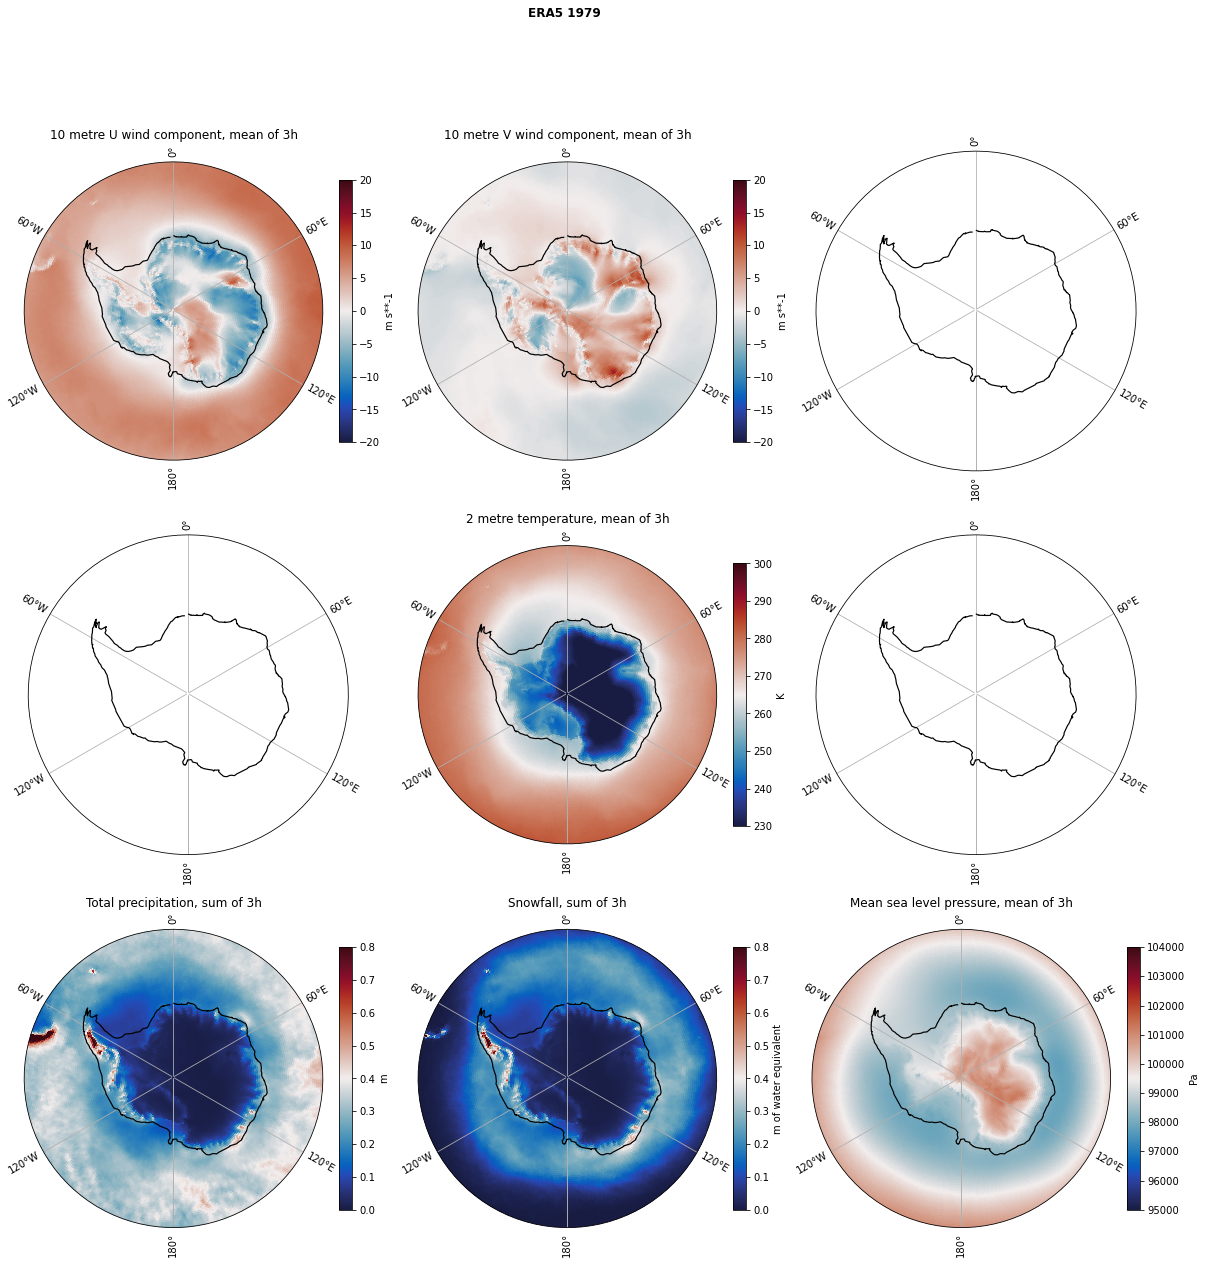

In [7]:
fig, ax = plt.subplots(3,3, figsize=(20,20), subplot_kw={'projection': ccrs.SouthPolarStereo()})

fig.suptitle('ERA5 1979', fontweight='bold')

ERA_vars = ['u10', 'v10', '', '', 't2m', '', 'tp', 'sf', 'msl']
vmins    = [-20, -20, 0, 100, 230, 0, 0, 0, 95000]
vmaxs    = [20, 20, 200, 450, 300, 0.01, 0.8, 0.8, 104000]
kwags    = {'transform':ccrs.PlateCarree(), 'cmap':cmocean.cm.balance, 'rasterized':True}

for n, axis in enumerate(ax.ravel()):
    axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    axis.set_boundary(map_circle, transform=axis.transAxes)
    gl = axis.gridlines(draw_labels=True, ylocs=[]);
    # add 2000 m isobath contour to each of the plots 
    axis.plot(x_iso1, y_iso1, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
    axis.plot(x_iso2, y_iso2, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

    try: # since some of the variables don't exist
        if ERA_vars[n] == 'tp' or ERA_vars[n] == 'sf': # for total precip and snow, calculate sum instead of mean
            axis.set_title(f'{ERA_1979[ERA_vars[n]].long_name}, sum of 3h')
    
            cm1 = axis.pcolormesh(ERA_1979.longitude, ERA_1979.latitude, ERA_1979[ERA_vars[n]].sum(dim='time'), 
                                  vmin=vmins[n], vmax=vmaxs[n], **kwags);
        else:
            axis.set_title(f'{ERA_1979[ERA_vars[n]].long_name}, mean of 3h')
            cm1 = axis.pcolormesh(ERA_1979.longitude, ERA_1979.latitude, ERA_1979[ERA_vars[n]].mean(dim='time'), 
                                  vmin=vmins[n], vmax=vmaxs[n], **kwags);

        CB = fig.colorbar(cm1, ax=axis, fraction=0.04)
        CB.set_label(ERA_1979[ERA_vars[n]].units)
    except:
        continue

fig.savefig('/home/users/birgal/data/forcing_NEMO/ERA5_1979.pdf', format='pdf')